# 1. Preparación del entorno en Google Colab

In [3]:
# Instalación de dependencias
!pip install scikit-learn pandas kagglehub

# Importar librerías
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer  # Para vectorización basada en conteos
from sklearn.naive_bayes import MultinomialNB  # Modelo Naive Bayes
from sklearn.model_selection import train_test_split  # Para dividir datos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import time, os, json, re
from pprint import pprint  # Para mostrar resultados legibles
import kagglehub
import nltk
from nltk.corpus import stopwords

# 2. Cargar el dataset

In [5]:
import pandas as pd

# - Usamos encoding 'latin-1' por compatibilidad con el formato del CSV
# Cargar el archivo con el delimitador correcto
# Cargar el archivo CSV
df = pd.read_csv('./IMDB Dataset.csv',encoding='utf-8')

# Ver las primeras filas para explorar la estructura
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# 3. Preprocesamiento de datos

In [6]:
# Comprobamos si hay nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# Guardamos df base antes de empezar a hacer cambios
df_base= df.copy()

In [8]:
import re
import nltk
from nltk.corpus import stopwords

# Descargar recursos de NLTK (solo la primera vez)
nltk.download('stopwords')

# Diccionario para reemplazar tildes
tildes = str.maketrans('áéíóúü', 'aeiouu')

# Función de limpieza mejorada para un solo texto
def limpiar_texto(text):
    # Convertir a minúsculas, eliminar saltos de línea, URLs, menciones, hashtags y puntuación
    text = re.sub(r'http\S+|@\S+|#\S+|[^\w\s]', '', text.lower())
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Reemplazar tildes
    text = text.translate(tildes)
    # Eliminar espacios extra
    return text.strip()

# Eliminar stopwords (en español o inglés según se necesite)
def eliminar_stopwords(text, language='english'):
    stop_words = set(stopwords.words(language))
    words = text.split()
    cleaned_text = ' '.join([word for word in words if word not in stop_words])
    return cleaned_text

# Aplicar limpieza y eliminación de stopwords
df["review"] = df["review"].apply(lambda x: eliminar_stopwords(limpiar_texto(x), language='english'))

print("Dataset con texto limpio y sin stopwords...")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset con texto limpio y sin stopwords...


# 4. División de datos en entrenamiento y prueba

In [9]:
# Reducir a 10,000 para rapidez
df = df.sample(10000, random_state=42)
X = df["review"]  # Textos
y = df["sentiment"]  # Etiquetas
print(f"Dataset listo: {df.shape} (filas, columnas)")

Dataset listo: (10000, 2) (filas, columnas)


In [10]:
df#Comprobemos si el texto está limpio

,review,sentiment
33553,really liked summerslam due look arena curtain...,positive
9427,many television shows appeal quite many differ...,positive
199,film quickly gets major chase scene ever incre...,negative
12447,jane austen would definitely approve onebr br ...,positive
39489,expectations somewhat high went see movie thou...,negative
...,...,...
28567,although casper van dien michael rooker genera...,negative
25079,liked movie wasnt really sure started watching...,positive
18707,yes nonsingaporeans cant see whats big deal fi...,positive
15200,far films go likable enough entertaining chara...,negative


In [11]:
from sklearn.model_selection import train_test_split

X = df['review']  # Características
y = df['sentiment']  # Etiquetas (positivo/negativo)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training Data: {len(X_train)} reviews")
print(f"Testing Data: {len(X_test)} reviews")

Training Data: 7000 reviews
Testing Data: 3000 reviews


# 5. Implementación del Modelo 1: TfidfVectorizer + Naive Bayes

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Crear el pipeline para el modelo
modelo_1 = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Entrenar el modelo
modelo_1.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_1 = modelo_1.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

    negative       0.83      0.88      0.85      1484
    positive       0.87      0.82      0.85      1516

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



# 6. Implementación del Modelo 2: CountVectorizer + SVM

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

# Crear el pipeline para el modelo
modelo_2 = make_pipeline(CountVectorizer(), SVC())

# Entrenar el modelo
modelo_2.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_2 = modelo_2.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

    negative       0.87      0.79      0.83      1484
    positive       0.81      0.89      0.85      1516

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



# 7. Comparar los resultados

In [14]:
# Comparar precisión
print("Modelo 1 - Naive Bayes (Tfidf):")
print(classification_report(y_test, y_pred_1))

print("Modelo 2 - SVM (CountVectorizer):")
print(classification_report(y_test, y_pred_2))

Modelo 1 - Naive Bayes (Tfidf):
              precision    recall  f1-score   support

    negative       0.83      0.88      0.85      1484
    positive       0.87      0.82      0.85      1516

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000

Modelo 2 - SVM (CountVectorizer):
              precision    recall  f1-score   support

    negative       0.87      0.79      0.83      1484
    positive       0.81      0.89      0.85      1516

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



# 8. Predicciones con nuevos datos

In [15]:
# Preparar nuevas reseñas de películas
nuevas_reseñas = [
    "This movie was amazing, I loved it!",
    "I didn't like it at all, the plot was very predictable.",
    "Great acting, but the story could have been better.",
    "Very boring, wouldn't recommend it to anyone."
]

# Preprocesar las nuevas reseñas usando la función de limpieza y stopwords en inglés
# Reutilizamos las funciones de limpieza y eliminación de stopwords que usaste previamente
nuevas_reseñas_limpias = [limpiar_texto(review) for review in nuevas_reseñas]
nuevas_reseñas_limpias = [eliminar_stopwords(review, language='english') for review in nuevas_reseñas_limpias]

# Predicción del sentimiento usando ambos modelos

# Predicción usando el Modelo 1 (Tfidf + Naive Bayes)
sentimiento_predicciones_modelo_1 = modelo_1.predict(nuevas_reseñas_limpias)

# Predicción usando el Modelo 2 (CountVectorizer + SVM)
sentimiento_predicciones_modelo_2 = modelo_2.predict(nuevas_reseñas_limpias)

# Paso 4: Comparar resultados
for review, sentiment_1, sentiment_2 in zip(nuevas_reseñas, sentimiento_predicciones_modelo_1, sentimiento_predicciones_modelo_2):
    print(f"Review: '{review}'")
    print(f"Predicted Sentiment (Naive Bayes with Tfidf): {'Positive' if sentiment_1 == 'positive' else 'Negative'}")
    print(f"Predicted Sentiment (SVM with CountVectorizer): {'Positive' if sentiment_2 == 'positive' else 'Negative'}")
    print("-" * 80)

Review: 'This movie was amazing, I loved it!'
Predicted Sentiment (Naive Bayes with Tfidf): Positive
Predicted Sentiment (SVM with CountVectorizer): Positive
--------------------------------------------------------------------------------
Review: 'I didn't like it at all, the plot was very predictable.'
Predicted Sentiment (Naive Bayes with Tfidf): Negative
Predicted Sentiment (SVM with CountVectorizer): Negative
--------------------------------------------------------------------------------
Review: 'Great acting, but the story could have been better.'
Predicted Sentiment (Naive Bayes with Tfidf): Negative
Predicted Sentiment (SVM with CountVectorizer): Positive
--------------------------------------------------------------------------------
Review: 'Very boring, wouldn't recommend it to anyone.'
Predicted Sentiment (Naive Bayes with Tfidf): Negative
Predicted Sentiment (SVM with CountVectorizer): Negative
-------------------------------------------------------------------------------

# 9. Mejoras en los modelos

In [19]:
df=df_base.copy() # volvemos a cargar df_base para poder aplicar nuevos cambios
# Función de limpieza para un solo texto
# Descargar recursos de NLTK (solo la primera vez)
nltk.download('stopwords')

# Diccionario para reemplazar tildes
tildes = str.maketrans('áéíóúü', 'aeiouu')

# Función de limpieza mejorada para un solo texto
def limpiar_texto(text):
    # Convertir a minúsculas, eliminar saltos de línea, URLs, menciones, hashtags y puntuación
    text = re.sub(r'http\S+|@\S+|#\S+|[^\w\s]', '', text.lower())
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Reemplazar tildes
    text = text.translate(tildes)
    # Eliminar espacios extra
    return text.strip()

# Eliminar stopwords (en español o inglés según se necesite)
def eliminar_stopwords(text, language='english'):
    stop_words = set(stopwords.words(language))
    words = text.split()
    cleaned_text = ' '.join([word for word in words if word not in stop_words])
    return cleaned_text

# Aplicar limpieza y eliminación de stopwords
df["review"] = df["review"].apply(lambda x: eliminar_stopwords(limpiar_texto(x), language='english'))

print("Dataset con texto limpio y sin stopwords...")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset con texto limpio y sin stopwords...


In [20]:
X = df["review"]  # Textos
y = df["sentiment"]  # Etiquetas
print(f"Dataset listo: {df.shape} (filas, columnas)")

Dataset listo: (50000, 2) (filas, columnas)


Matriz CountVectorizer creada: (50000, 10000) (documentos, características)
Dataset después de SMOTE: 50000 instancias
Modelo Naive Bayes entrenado
Evaluación con umbral ajustado:
              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      4961
    positive       0.86      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Precisión media con validación cruzada: 0.8573


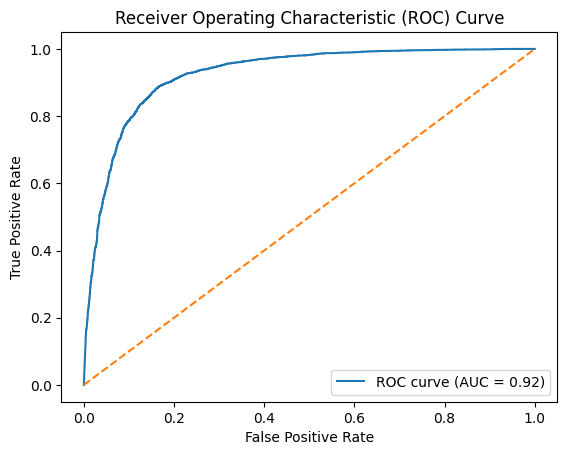

AUC (Área bajo la curva ROC): 0.92


In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import time

# Paso 1: Vectorización CountVectorizer con ajustes: aumentamos max_features e introducimos ngram_range y min_df
vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5)
X_vec = vectorizer.fit_transform(X)  # Transformar textos a matriz de conteos absolutos
print(f"Matriz CountVectorizer creada: {X_vec.shape} (documentos, características)")

# Paso 2: Aplicar SMOTE para sobremuestreo de la clase minoritaria
smote = SMOTE(random_state=42)
X_vec_smote, y_smote = smote.fit_resample(X_vec, y)
print(f"Dataset después de SMOTE: {X_vec_smote.shape[0]} instancias")

# Paso 3: Dividir datos en entrenamiento y prueba después de SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_vec_smote, y_smote, test_size=0.2, random_state=42)

# Paso 4: Calcular pesos de las muestras (mayor peso a la clase 0)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Paso 5: Entrenar modelo Naive Bayes con sample_weight
start_time = time.time()
modelCountVectorizer_MultinomialNB = MultinomialNB()
modelCountVectorizer_MultinomialNB.fit(X_train, y_train, sample_weight=sample_weights)
print("Modelo Naive Bayes entrenado")

# Paso 6: Hacer predicciones de probabilidades
y_prob = modelCountVectorizer_MultinomialNB.predict_proba(X_test)[:, 1]

# Paso 7: Ajustar el umbral de decisión (por ejemplo, a 0.6)
threshold = 0.6
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Convertir las predicciones de 0/1 a 'negative'/'positive'
y_pred_adjusted = ['positive' if pred == 1 else 'negative' for pred in y_pred_adjusted]

# Paso 8: Evaluar el rendimiento con el umbral ajustado
print("Evaluación con umbral ajustado:")
print(classification_report(y_test, y_pred_adjusted))

# Paso 9: Validación cruzada (opcional, para evaluar el modelo)
cross_val_scores = cross_val_score(modelCountVectorizer_MultinomialNB, X_vec_smote, y_smote, cv=5, scoring='accuracy')
print(f"Precisión media con validación cruzada: {cross_val_scores.mean():.4f}")

# Paso 10: Curva ROC y AUC para visualizar el rendimiento del modelo
# Convertir las etiquetas verdaderas a valores numéricos
y_test_numeric = [1 if label == 'positive' else 0 for label in y_test]

# Convertir las predicciones ajustadas a valores numéricos
y_pred_adjusted_numeric = [1 if label == 'positive' else 0 for label in y_pred_adjusted]

# Calcular la curva ROC y AUC
fpr, tpr, thresholds_roc = roc_curve(y_test_numeric, y_prob)
auc = roc_auc_score(y_test_numeric, y_prob)

# Mostrar la curva ROC
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Mostrar el AUC
print(f"AUC (Área bajo la curva ROC): {auc:.2f}")

In [31]:
# Preparar nuevas reseñas de películas
nuevas_reseñas = [
    "This movie was amazing, I loved it!",
    "I didn't like it at all, the plot was very predictable.",
    "Great acting, but the story could have been better.",
    "Very boring, wouldn't recommend it to anyone."
]

# Preprocesar las nuevas reseñas usando la función de limpieza y stopwords en inglés
# Reutilizamos las funciones de limpieza y eliminación de stopwords que usaste previamente
nuevas_reseñas_limpias = [limpiar_texto(review) for review in nuevas_reseñas]
nuevas_reseñas_limpias = [eliminar_stopwords(review, language='english') for review in nuevas_reseñas_limpias]

# Predicción del sentimiento usando ambos modelos

# Predicción usando el Modelo 1 (Tfidf + Naive Bayes)
sentimiento_predicciones_modelo_1 = modelo_1.predict(nuevas_reseñas_limpias)

# Predicción usando el Modelo 2 (CountVectorizer + SVM)
sentimiento_predicciones_modelo_2 = modelo_2.predict(nuevas_reseñas_limpias)

# Predicción usando el Modelo 3 (Naive Bayes + CountVectorizer)
sentimiento_predicciones_modelo_3 = modelCountVectorizer_MultinomialNB.predict(vectorizer.transform(nuevas_reseñas_limpias))

# Paso 4: Comparar resultados
for review, sentiment_1, sentiment_2, sentiment_3 in zip(nuevas_reseñas, sentimiento_predicciones_modelo_1, sentimiento_predicciones_modelo_2, sentimiento_predicciones_modelo_3):
    print(f"Review: '{review}'")
    print(f"Predicted Sentiment (Naive Bayes with Tfidf): {'Positive' if sentiment_1 == 'positive' else 'Negative'}")
    print(f"Predicted Sentiment (SVM with CountVectorizer): {'Positive' if sentiment_2 == 'positive' else 'Negative'}")
    print(f"Predicted Sentiment (Naive Bayes with CountVectorizer): {'Positive' if sentiment_3 == 'positive' else 'Negative'}")
    print("-" * 80)


Review: 'This movie was amazing, I loved it!'
Predicted Sentiment (Naive Bayes with Tfidf): Positive
Predicted Sentiment (SVM with CountVectorizer): Positive
Predicted Sentiment (Naive Bayes with CountVectorizer): Positive
--------------------------------------------------------------------------------
Review: 'I didn't like it at all, the plot was very predictable.'
Predicted Sentiment (Naive Bayes with Tfidf): Negative
Predicted Sentiment (SVM with CountVectorizer): Negative
Predicted Sentiment (Naive Bayes with CountVectorizer): Negative
--------------------------------------------------------------------------------
Review: 'Great acting, but the story could have been better.'
Predicted Sentiment (Naive Bayes with Tfidf): Negative
Predicted Sentiment (SVM with CountVectorizer): Positive
Predicted Sentiment (Naive Bayes with CountVectorizer): Positive
--------------------------------------------------------------------------------
Review: 'Very boring, wouldn't recommend it to anyon

In [22]:
pip install joblib

In [24]:
import joblib

# Guardar el modelo entrenado
joblib.dump(modelCountVectorizer_MultinomialNB, './model_countvectorizer_nb.pkl')

# Guardar el vectorizador
joblib.dump(vectorizer, './vectorizer.pkl')

print("Modelo y vectorizador guardados correctamente.")

Modelo y vectorizador guardados correctamente.


In [26]:
!python --version

Python 3.11.12
